In [4]:
import numpy as np
import pandas as pd
from google.cloud import storage

def generate_train_eval_data(bucket_name, my_prefix):
    """
    """
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blobs_all = list(bucket.list_blobs(prefix=my_prefix))
    gcs_data = []
    for x in blobs_all:
        #Select only image files
        if x.name.endswith(('.png','.jpg','.jpeg')):
            gcs_data.append(['gs://'+bucket_name+'/'+x.name,x.name.split('/')[-2]])
    
    df = pd.DataFrame(gcs_data)
    df.to_csv('text.csv', index = False,header=False)
    full_out_path=f'gs://{bucket_name}/{my_prefix}full_list.csv'
    train_data = df.sample(frac = 0.8)
    train_data.to_csv('train_set.csv', index = False,header=False)
    train_data_path = f'gs://{bucket_name}/{my_prefix}train_set.csv'
    eval_data = df.drop(train_data.index)
    eval_data.to_csv('eval_set.csv', index = False,header=False)
    eval_data_path=f'gs://{bucket_name}/{my_prefix}eval_set.csv'
    
    return train_data_path, eval_data_path

    

In [ ]:
#train_data=f'gs://{bucket_name}/{my_prefix}train_set2.csv'
#eval_data=f'gs://{bucket_name}/{my_prefix}eval_set2.csv'
#test_data=f'gs://{bucket_name}/{my_prefix}test_set2.csv'


In [5]:
def get_class_names(train_data):
    df = pd.read_csv(train_data, header=None,   dtype={ 'imagepath': str,'cat': np.float32  })
    CLASS_NAMES = [str(x) for x in df[1].unique().tolist()]
    return CLASS_NAMES


my_prefix='imgs/euro/'
bucket_name = "team4-cash-classify45"
train_data_path, eval_data_path = generate_train_eval_data(bucket_name, my_prefix)
print (train_data_path, eval_data_path)

CLASS_NAMES = get_class_names(train_data_path)
print (CLASS_NAMES)

gs://team4-cash-classify45/imgs/euro/train_set.csv gs://team4-cash-classify45/imgs/euro/eval_set.csv
['20', '10', '5', '200', '500', '50', '100']


In [26]:
!gsutil cp train_set.csv gs://team4-cash-classify45/imgs/euro/train_set.csv
!gsutil cp eval_set.csv gs://team4-cash-classify45/imgs/euro/eval_set.csv


Copying file://train_set.csv [Content-Type=text/csv]...
/ [1 files][ 41.2 KiB/ 41.2 KiB]                                                
Operation completed over 1 objects/41.2 KiB.                                     
Copying file://eval_set.csv [Content-Type=text/csv]...
/ [1 files][ 10.4 KiB/ 10.4 KiB]                                                
Operation completed over 1 objects/10.4 KiB.                                     


In [6]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(model, filename):
  f, ax = plt.subplots(7, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(35)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);a
    ax[flower].axis('off')


def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)



# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

In [7]:
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# parameterize to the values in the previous cell
def create_model(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)



  # train_dataset2 = tf.keras.layers.RandomFlip()(train_dataset)
  #eval_dataset2 = tf.keras.layers.RandomFlip()(eval_dataset2)

  layers = [
      #tf.keras.layers.Rescaling(1.0 / 255),
      # Convert the compressed string to a 3D uint8 tensor.
      #tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
      # Use `convert_image_dtype` to convert to floats in the [0,1] range.
      #tf.image.convert_image_dtype(img, tf.float32)
      # Resize the image to the desired size.
      #tf.image.resize(img, reshape_dims)
      tf.keras.layers.RandomFlip(),
      tf.keras.layers.RandomRotation(0.1),
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),

      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation='relu',
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  # model.build()
  # print(model.summary())
  #history = model.fit(train_data, validation_data=eval_data, epochs=2)
  #training_plot(['loss', 'accuracy'], history)
  return model



In [8]:
def train_and_evaluate(model,epochs,train_data,eval_data,batch_size=32):
  train_dataset = (tf.data.TextLineDataset(
      train_data).
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      eval_data).
      map(decode_csv)).batch(32) # this doesn't matter
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=epochs)
  training_plot(['loss', 'accuracy'], history)
  return model

In [27]:
model=create_model()

Epoch 1/2
20/20 [==============================] - 74s 3s/step - loss: 1.6140 - accuracy: 0.4328 - val_loss: 1.4360 - val_accuracy: 0.4250
Epoch 2/2
20/20 [==============================] - 51s 3s/step - loss: 1.3365 - accuracy: 0.5047 - val_loss: 1.2865 - val_accuracy: 0.4437


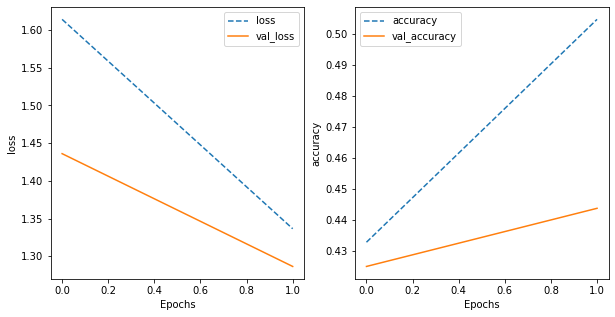

In [28]:
model = train_and_evaluate(model,2,train_data_path,eval_data_path)

In [29]:
plot_predictions(model, test_data)

NameError: name 'test_data' is not defined

In [30]:
# Save Model Iteration
model.save(f'gs://{bucket_name}/modelv2')

2022-04-28 16:17:26.650964: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://team4-cash-classify45/modelv2/assets


INFO:tensorflow:Assets written to: gs://team4-cash-classify45/modelv2/assets


In [ ]:
train_data=f'gs://{bucket_name}/{my_prefix}train_set2.csv'
eval_data=f'gs://{bucket_name}/{my_prefix}eval_set2.csv'
test_data=f'gs://{bucket_name}/{my_prefix}test_set2.csv'

In [14]:
%%writefile models/utils.py
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os
import fire
import tensorflow as tf

# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(model, filename):
  f, ax = plt.subplots(7, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(35)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);a
    ax[flower].axis('off')


def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)



# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label


Overwriting models/utils.py


In [15]:
%%writefile models/train.py

import fire
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

from models.utils import training_plot, plot_predictions, show_trained_weights, read_and_decode, decode_csv


IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# parameterize to the values in the previous cell
def create_model(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16, CLASS_NAMES=['20', '50', '5', '10']):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)



  # train_dataset2 = tf.keras.layers.RandomFlip()(train_dataset)
  #eval_dataset2 = tf.keras.layers.RandomFlip()(eval_dataset2)

  layers = [
      #tf.keras.layers.Rescaling(1.0 / 255),
      # Convert the compressed string to a 3D uint8 tensor.
      #tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
      # Use `convert_image_dtype` to convert to floats in the [0,1] range.
      #tf.image.convert_image_dtype(img, tf.float32)
      # Resize the image to the desired size.
      #tf.image.resize(img, reshape_dims)
      tf.keras.layers.RandomFlip(),
      tf.keras.layers.RandomRotation(0.1),
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),

      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation='relu',
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  # model.build()
  # print(model.summary())
  #history = model.fit(train_data, validation_data=eval_data, epochs=2)
  #training_plot(['loss', 'accuracy'], history)
  return model

def train_and_evaluate(model,epochs,train_data,eval_data,batch_size=32):
  train_dataset = (tf.data.TextLineDataset(
      train_data).
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      eval_data).
      map(decode_csv)).batch(32) # this doesn't matter
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=epochs)
  training_plot(['loss', 'accuracy'], history)
  return model


def train_and_evaluate_cash(train_data, eval_data, bucket_name, class_names):    
    model=create_model(CLASS_NAMES=class_names)
    model = train_and_evaluate(model,2,train_data_path,eval_data_path)
    # Save Model Iteration
    model.save(f'gs://{bucket_name}/modelv2')

if __name__ == "__main__":
    fire.Fire(train_and_evaluate_cash)
    

Overwriting models/train.py


['20', '10', '5', '200', '500', '50', '100']
Epoch 1/2
20/20 [==============================] - 65s 3s/step - loss: 1.5484 - accuracy: 0.4297 - val_loss: 1.3469 - val_accuracy: 0.5063
Epoch 2/2
20/20 [==============================] - 54s 3s/step - loss: 1.1464 - accuracy: 0.5891 - val_loss: 1.0495 - val_accuracy: 0.6062
INFO:tensorflow:Assets written to: gs://team4-cash-classify45/modelv2/assets


INFO:tensorflow:Assets written to: gs://team4-cash-classify45/modelv2/assets


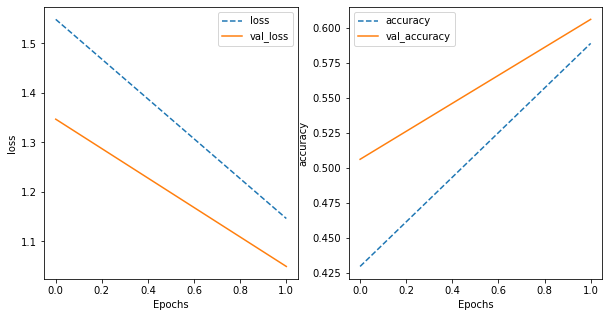

In [16]:
bucket_name = "team4-cash-classify45"
CLASS_NAMES = get_class_names(train_data_path)
print (CLASS_NAMES)

train_and_evaluate_cash(train_data_path, eval_data_path, bucket_name, CLASS_NAMES)

In [26]:
%%bash 
touch models/__init__.py



In [28]:
OUTDIR = f"gs://team4-cash-classify45/model_v1"

os.environ["OUTDIR"] = OUTDIR

In [17]:
%%writefile models/setup.py

from setuptools import find_packages
from setuptools import setup

setup(
    name='cash_classify',
    version='0.1',
    packages=find_packages(),
    include_package_data=True,
    install_requires=['fire==0.4.0'],
    description='cash image classifier training application.'
)

Writing models/setup.py


In [18]:
%%bash
cd models
python ./setup.py sdist --formats=gztar
cd ..

running sdist
running egg_info
creating cash_classify.egg-info
writing cash_classify.egg-info/PKG-INFO
writing dependency_links to cash_classify.egg-info/dependency_links.txt
writing requirements to cash_classify.egg-info/requires.txt
writing top-level names to cash_classify.egg-info/top_level.txt
writing manifest file 'cash_classify.egg-info/SOURCES.txt'
reading manifest file 'cash_classify.egg-info/SOURCES.txt'
writing manifest file 'cash_classify.egg-info/SOURCES.txt'
running check
creating cash_classify-0.1
creating cash_classify-0.1/cash_classify.egg-info
copying files to cash_classify-0.1...
copying setup.py -> cash_classify-0.1
copying cash_classify.egg-info/PKG-INFO -> cash_classify-0.1/cash_classify.egg-info
copying cash_classify.egg-info/SOURCES.txt -> cash_classify-0.1/cash_classify.egg-info
copying cash_classify.egg-info/dependency_links.txt -> cash_classify-0.1/cash_classify.egg-info
copying cash_classify.egg-info/requires.txt -> cash_classify-0.1/cash_classify.egg-info
co

In [22]:
!gsutil cp models/dist/cash_classify-0.1.tar.gz gs://team4-cash-classify45/

BUCKET = "team4-cash-classify45"

Copying file://models/dist/cash_classify-0.1.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  674.0 B/  674.0 B]                                                
Operation completed over 1 objects/674.0 B.                                      


In [29]:
%%bash
JOB_NAME=cash_${TIMESTAMP}
OUTDIR_LOCAL=local_test_training
PYTHON_PACKAGE_URI=gs://team4-cash-classify45/cash_classify-0.1.tar.gz
PYTHON_PACKAGE_EXECUTOR_IMAGE_URI="us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-3:latest"
PYTHON_MODULE=trainer.train

echo > ./config.yaml \
"workerPoolSpecs:
  machineSpec:
    machineType: n1-standard-8
  replicaCount: 1
  pythonPackageSpec:
    executorImageUri: $PYTHON_PACKAGE_EXECUTOR_IMAGE_URI
    packageUris: $PYTHON_PACKAGE_URI
    pythonModule: $PYTHON_MODULE
    args:
    - --train_data_path=train_data_path
    - --eval_data_path=eval_data_path
    - --output_dir=$OUTDIR
    - --num_epochs=15
    - --train_examples=15000
    - --batch_size=32
    "

gcloud ai custom-jobs create \
  --region=${REGION} \
  --display-name=$JOB_NAME \
  --config=config.yaml

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
CustomJob [projects/310019774109/locations/us-central1/customJobs/3040508641347108864] is submitted successfully.

Your job is still active. You may view the status of your job with the command

  $ gcloud ai custom-jobs describe projects/310019774109/locations/us-central1/customJobs/3040508641347108864

or continue streaming the logs with the command

  $ gcloud ai custom-jobs stream-logs projects/310019774109/locations/us-central1/customJobs/3040508641347108864


In [40]:
local_model = tf.keras.models.load_model(f'gs://team4-cash-classify45/modelv2')

In [35]:
local_model.summary()

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 7)                 119       
                                                                 
Total params: 2,278,599
Trainable params: 20,

In [38]:
CONCRETE_INPUT = "numpy_inputs"


def _preprocess(bytes_input):
    decoded = tf.io.decode_jpeg(bytes_input, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    resized = tf.image.resize(decoded, size=(IMG_HEIGHT, IMG_WIDTH))
    rescale = tf.cast(resized / 255.0, tf.float32)
    return rescale


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def preprocess_fn(bytes_inputs):
    decoded_images = tf.map_fn(
        _preprocess, bytes_inputs, dtype=tf.float32, back_prop=False
    )
    return {
        CONCRETE_INPUT: decoded_images
    }  # User needs to make sure the key matches model's input


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def serving_fn(bytes_inputs):
    images = preprocess_fn(bytes_inputs)
    prob = m_call(**images)
    return prob


# the function that sends data through the model itself and returns
# the output probabilities
m_call = tf.function(local_model.call).get_concrete_function(
    [
        tf.TensorSpec(
            shape=[None, IMG_HEIGHT, IMG_WIDTH, 3], dtype=tf.float32, name=CONCRETE_INPUT
        )
    ]
)

tf.saved_model.save(
    local_model,
    OUTDIR,
    signatures={
        "serving_default": serving_fn,
        # Required for XAI
        "xai_preprocess": preprocess_fn,
        "xai_model": m_call,
    },
)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


INFO:tensorflow:Assets written to: gs://team4-cash-classify45/model_v1/assets


INFO:tensorflow:Assets written to: gs://team4-cash-classify45/model_v1/assets


In [41]:
loaded = tf.saved_model.load(OUTDIR)

serving_input = list(
    loaded.signatures["serving_default"].structured_input_signature[1].keys()
)[0]
print("Serving function input:", serving_input)
serving_output = list(
    loaded.signatures["serving_default"].structured_outputs.keys()
)[0]
print("Serving function output:", serving_output)

input_name = local_model.input.name
print("Model input name:", input_name)
output_name = local_model.output.name
print("Model output name:", output_name)

Serving function input: bytes_inputs
Serving function output: output_0
Model input name: random_flip_1_input
Model output name: flower_prob/Softmax:0


In [43]:
import base64
import os
import random
from datetime import datetime

import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from google.cloud import aiplatform
from matplotlib import pyplot as plt

parameters = aiplatform.explain.ExplanationParameters(
    {"integrated_gradients_attribution": {"step_count": 50}}
)

In [44]:
MODEL_NAME = "cash_classifier_v2"
INPUT_METADATA = {"input_tensor_name": CONCRETE_INPUT, "modality": "image"}
OUTPUT_METADATA = {"output_tensor_name": serving_output}

input_metadata = aiplatform.explain.ExplanationMetadata.InputMetadata(
    INPUT_METADATA
)
output_metadata = aiplatform.explain.ExplanationMetadata.OutputMetadata(
    OUTPUT_METADATA
)

metadata = aiplatform.explain.ExplanationMetadata(
    inputs={"image": input_metadata}, outputs={"class": output_metadata}
)

In [46]:
#Pipeline
from google.cloud import aiplatform
REGION = "us-central1"
PROJECT_ID = !(gcloud config get-value project)
PROJECT = PROJECT_ID[0]
print (PROJECT)

qwiklabs-gcp-01-64654318344c


In [51]:
aiplatform.init(project=PROJECT, staging_bucket=f'gs://team4-cash-classify45')
model = aiplatform.Model.upload(
    display_name=MODEL_NAME,
    artifact_uri=OUTDIR,
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest",
    explanation_parameters=parameters,
    explanation_metadata=metadata,
    sync=False,
)

model.wait()

InternalServerError: 500 Internal error occurred. Please retry in a few minutes. If you still experience errors, contact Vertex AI.

In [50]:
endpoint = model.deploy(
    deployed_model_display_name=MODEL_NAME,
    traffic_split={"0": 100},
    machine_type="n1-standard-4",
    min_replica_count=1,
    max_replica_count=1,
)

InternalServerError: 500 Internal error occurred. Please retry in a few minutes. If you still experience errors, contact Vertex AI.

In [52]:
endpoint = model.deploy(
    deployed_model_display_name=MODEL_NAME,
    traffic_split={"0": 100},
    machine_type="n1-standard-4",
    min_replica_count=1,
    max_replica_count=1,
)

InternalServerError: 500 Internal error occurred. Please retry in a few minutes. If you still experience errors, contact Vertex AI.

In [53]:
eval_ds = load_dataset(EVAL_DATA_PATH)
x_test, y_test = dataset_to_numpy(eval_ds, 5)

# Single image from eval dataset
test_image = x_test[0] * 255.0

# Write image out as jpg
cv2.imwrite("tmp.jpg", test_image)

NameError: name 'load_dataset' is not defined